# Reference
https://cnvrg.io/seq2seq-model/

source tokens {'19.': 0, 'Ask': 1, 'Attack!': 2, 'Awesome!': 3, 'Be': 4, 'Beat': 5, 'Call': 6, 'Cheers!': 7, 'Come': 8, 'Drop': 9, 'Fire!': 10, 'Get': 11, 'Go': 12, 'Go.': 13, 'Got': 14, 'Help!': 15, 'Hop': 16, 'Hug': 17, 'I': 18, "I'm": 19, 'Jump.': 20, 'Listen.': 21, 'No': 22, 'OK.': 23, 'Oh': 24, 'Really?': 25, 'Run!': 26, 'Stop!': 27, 'Thanks.': 28, 'Tom.': 29, 'Wait!': 30, 'We': 31, 'Wow!': 32, 'calm.': 33, 'cool.': 34, 'fair.': 35, 'fell.': 36, 'in.': 37, 'it!': 38, 'it.': 39, 'it?': 40, 'kind.': 41, 'know.': 42, 'left.': 43, 'lost.': 44, 'me.': 45, 'nice.': 46, 'no!': 47, 'now.': 48, 'on!': 49, 'on.': 50, 'see.': 51, 'try.': 52, 'up.': 53, 'us.': 54, 'way!': 55, 'won!': 56, 'won.': 57}
target tokens: {'!': 0, '19': 1, '?': 2, 'Ah': 3, 'Allez': 4, 'Allez-y': 5, 'Appelez-nous': 6, 'Appelle-moi': 7, 'Appelle-nous': 8, 'Appellez-moi': 9, 'Arrête-toi': 10, 'Attaque': 11, 'Attaquez': 12, 'Attendez': 13, 'Attends': 14, 'Au': 15, "C'est": 16, 'Compris': 17, 'Continuez.': 18, 'Courez': 1

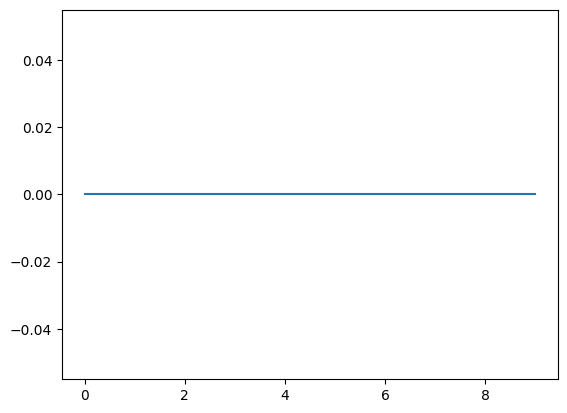

{'loss': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'acc': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'val_loss': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'val_acc': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}
1/1 [==============================] - 0s 434ms/step
decoded 
1/1 [==============================] - 0s 18ms/step
decoded  cas.
1/1 [==============================] - 0s 19ms/step
decoded  cas. cas.
1/1 [==============================] - 0s 35ms/step
decoded  cas. cas. tes
1/1 [==============================] - 0s 34ms/step
decoded  cas. cas. tes tes
1/1 [==============================] - 0s 26ms/step
decoded  cas. cas. tes tes tes
1/1 [==============================] - 0s 29ms/step
decoded  cas. cas. tes tes tes tes
1/1 [==============================] - 0s 26ms/step
decoded  cas. cas. tes tes tes tes tes
1/1 [==============================] - 0s 33ms/step
decoded  cas. cas. tes tes tes tes tes tes
1/1 [==============================] - 0s 32

In [27]:
import sys
import pandas as pd
import numpy as np
import string
from string import digits
import re
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt 


embedding_size = 50

def get_data ():
    lines= pd.read_table('fra.txt', names=['eng','fr'])
    lines = lines[:100]
    return lines 



def preprocess(lines):
    lines.eng=lines.eng.apply(lambda x: x.lower())
    lines.fr=lines.fr.apply(lambda x: x.lower())
    lines.eng=lines.eng.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))
    lines.fr=lines.fr.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))
    exclude = set(string.punctuation)
    lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
    lines.fr=lines.fr.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
    remove_digits = str.maketrans('', '', digits)
    lines.eng=lines.eng.apply(lambda x: x.translate(remove_digits))
    lines.fr=lines.fr.apply(lambda x: x.translate(remove_digits))
    lines.fr = lines.fr.apply(lambda x : 'START_ '+ x + ' _END')
    return lines 


class Seq2Seq_Model:
    def __init__(self, num_encoder_tokens, num_decoder_tokens):
        self.num_encoder_tokens = num_encoder_tokens
        self.num_decoder_tokens = num_decoder_tokens
        self.model = None
        self.encoder_model = None 
        self.decoder_model = None
        self.get_models ()
        
    def get_models (self):
        
        encoder_inputs = Input(shape=(None,))
        en_x =  Embedding(self.num_encoder_tokens-1, embedding_size)(encoder_inputs)
        encoder = LSTM(50, return_state=True)
        encoder_outputs, state_h, state_c = encoder(en_x)

        # We discard `encoder_outputs` and only keep the states.
        encoder_states = [state_h, state_c]

        decoder_inputs = Input(shape=(None,))
        dex =  Embedding(num_decoder_tokens-1, embedding_size)
        final_dex= dex(decoder_inputs)

        decoder_lstm = LSTM(50, return_sequences=True, return_state=True)
        decoder_outputs, _, _ = decoder_lstm(final_dex, initial_state=encoder_states)
        decoder_dense = Dense(num_decoder_tokens, activation='softmax')
        decoder_outputs = decoder_dense(decoder_outputs)

        self.model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

        self.encoder_model = Model(encoder_inputs, encoder_states)
    
        decoder_state_input_h = Input(shape=(50,))
        decoder_state_input_c = Input(shape=(50,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

        final_dex2 = dex(decoder_inputs)
        decoder_outputs2, state_h2, state_c2 = decoder_lstm(final_dex2, initial_state=decoder_states_inputs)
        decoder_states2 = [state_h2, state_c2]
        decoder_outputs2 = decoder_dense(decoder_outputs2)
        self.decoder_model = Model([decoder_inputs] + decoder_states_inputs,[decoder_outputs2] + decoder_states2)
    
    def fit_model (self, encoder_input_data, decoder_input_data, decoder_target_data):
 
        self.model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['acc'])
        
        hist = self.model.fit([encoder_input_data, decoder_input_data], decoder_target_data,batch_size=128, epochs=10,
         validation_split=0.05)
   
        return hist 




def decode_sequence(input_seq, M, input_token_index, target_token_index):
    target_token_index['START_'] = 1
    
    reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
    reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

    encoder_model =  M.encoder_model 
    decoder_model =  M.decoder_model 
     
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False

    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) 
        sampled_char = reverse_target_char_index[sampled_token_index]
        print("decoded", decoded_sentence)
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or len(decoded_sentence) > 52):
             stop_condition = True
    
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # Update states
        states_value = [h, c]
    return decoded_sentence


def preproc (lines):
    all_eng_words=set()
    for eng in lines.eng:
        for word in eng.split():
            if word not in all_eng_words:
                all_eng_words.add(word)

    all_french_words=set()
    for fr in lines.fr:
        for word in fr.split():
            if word not in all_french_words:
                all_french_words.add(word)

    input_words = sorted(list(all_eng_words))
    target_words = sorted(list(all_french_words))
    num_encoder_tokens = len(all_eng_words)
    num_decoder_tokens = len(all_french_words)

    input_token_index = dict([(word, i) for i, word in enumerate(input_words)])
    target_token_index = dict([(word, i) for i, word in enumerate(target_words)])
    return num_encoder_tokens, num_decoder_tokens, input_token_index, target_token_index 


def tokenization (lines, eng_dict, fr_dict):
   
    encoder_input_data = np.zeros((len(lines.eng), 7),dtype='float32')
    decoder_input_data = np.zeros((len(lines.fr), 16),dtype='float32')
    decoder_target_data = np.zeros((len(lines.fr), 16, num_decoder_tokens), dtype='float32')

    eng = lines.eng
    fr = lines.fr
    encoder_input_data= []
    decoder_input_data = []

    for i in range (0, len (eng)):
        src = eng[i].split(" ")
        tgt =  fr[i].split(" ")
        #tgt = ['START_']  + tgt + ['END_'] 
        src = [ eng_dict[k] for k in src if k in eng_dict]  
        tgt = [ fr_dict[k] for k in tgt if k in fr_dict] 
        #src = [eng_dict['PAD_']] * ( 7- len (src)) + src 
        #tgt = [fr_dict['PAD_']] * (16 - len(tgt)) + tgt 
        encoder_input_data.append (src)
        decoder_input_data.append (tgt)
        
    return encoder_input_data, decoder_input_data



if __name__ == "__main__":
    num_encoder_tokens = 1000
    num_decoder_tokens = 2000
    
    lines = get_data () 

    #lines  = preprocess(lines)
    



    
    #print("lines",lines)
    
    num_encoder_tokens, num_decoder_tokens, input_token_index, target_token_index = preproc (lines)


    #target_token_index['START_'] = len (target_token_index.keys()) 
    #target_token_index['END_'] = len (target_token_index.keys()) 
    #target_token_index['PAD_'] = len (target_token_index.keys()) 

    #input_token_index['PAD_'] = len (input_token_index.keys()) 
    
    print("source tokens", input_token_index)
    print("target tokens:", target_token_index)
    #sys.exit()
    
    print(num_encoder_tokens, num_decoder_tokens, input_token_index, target_token_index )
    
    encoder_input_data = np.zeros((len(lines.eng), 7),dtype='float32')
    decoder_input_data = np.zeros((len(lines.fr), 16),dtype='float32')
    ecoder_target_data = np.zeros((len(lines.fr), 16, num_decoder_tokens), dtype='float32')

    #print(encoder_input_data)
    #encoder_input_data, decoder_input_data  = tokenization (lines, input_token_index, target_token_index )
    #decoder_input_data = np.zeros((len(lines.fr), 16),dtype='float32')
    #sys.exit()
    
    M = Seq2Seq_Model (num_encoder_tokens, num_decoder_tokens)

    print(M.model.summary())
    
    hist = M.fit_model (encoder_input_data, decoder_input_data, decoder_target_data)

    plt.plot(hist.history['acc'])
    plt.show()
    print(hist.history)
    
    for seq_index in [91,2,45,40]:
       input_seq = encoder_input_data[seq_index: seq_index + 1]
       decoded_sentence = decode_sequence(input_seq, M, input_token_index, target_token_index)
    #    print('-')
    #    print('Input sentence:', lines.eng[seq_index: seq_index + 1])
    #    print('Decoded sentence:', decoded_sentence)
                       